In [82]:
#!pip install kaggle --upgrade

In [83]:
import zipfile
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import transforms
from scipy.stats import gaussian_kde
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [84]:
if not os.path.isdir("data"):
    with zipfile.ZipFile(file='airbnb_data.zip', mode='r') as zip_ref:
        zip_ref.extractall(path='data')

In [85]:
df = pd.read_csv("data/AB_NYC_2019.csv",index_col=0)
print(df.shape)

(48895, 15)


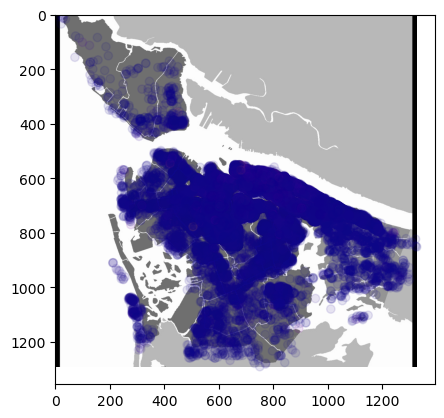

In [86]:
img = Image.open("data/New_York_City_.jpeg").rotate(270)
fig, ax = plt.subplots()

width,height = img.size

transp_lat =(df["latitude"]-df["latitude"].min())/(df["latitude"].max()-df["latitude"].min())*width
transp_long =(df["longitude"]-df["longitude"].min())/(df["longitude"].max()-df["longitude"].min())*height

ax.imshow(img)
colors = (df["price"]-df["price"].min())/(df["price"].max()-df["price"].min())

ax.scatter(transp_lat,transp_long, c=df["price"],alpha=0.1,cmap="plasma")


### Missing Values

<AxesSubplot:>

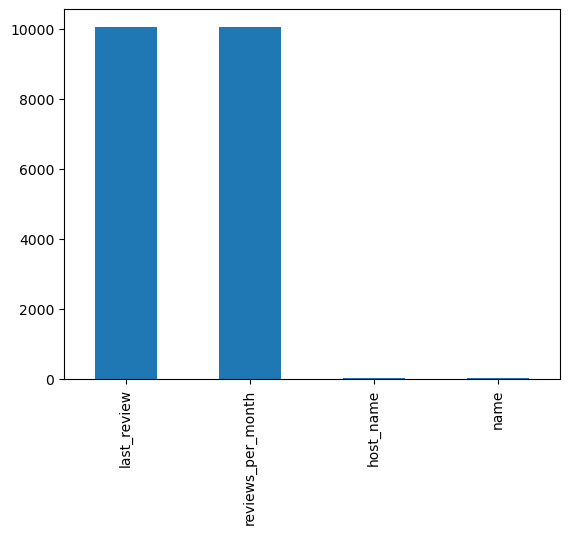

In [87]:
missing = pd.isna(df).sum().sort_values(ascending=False)
missing[missing >0].plot.bar()

<AxesSubplot:>

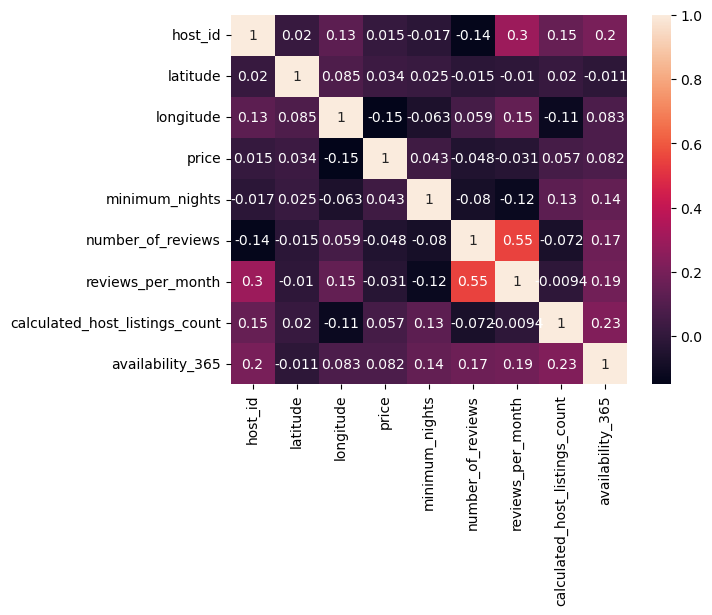

In [88]:
corr_mat = df.corr()
sns.heatmap(corr_mat,annot=True)

In [89]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']
print(df.columns)

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [90]:
y = df.pop("price")
X = df[["minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365","room_type","neighbourhood_group","neighbourhood"]]

In [91]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False), ["room_type","neighbourhood_group","neighbourhood"]),
    remainder='passthrough')
transformed = transformer.fit_transform(X)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
print(transformed_df)


       onehotencoder__x0_Entire home/apt  onehotencoder__x0_Private room  \
0                                    0.0                             1.0   
1                                    1.0                             0.0   
2                                    0.0                             1.0   
3                                    1.0                             0.0   
4                                    1.0                             0.0   
...                                  ...                             ...   
48890                                0.0                             1.0   
48891                                0.0                             1.0   
48892                                1.0                             0.0   
48893                                0.0                             0.0   
48894                                0.0                             1.0   

       onehotencoder__x0_Shared room  onehotencoder__x1_Bronx  \
0                     

c:\Users\nemet\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
transformer2 = make_column_transformer(
    (StandardScaler(), ["minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365"]),
    remainder='passthrough')
transformed2 = transformer2.fit_transform(transformed_df)
transformed_df2 = pd.DataFrame(
    transformed2, 
    columns=transformed_df.columns
)
print(transformed_df2.describe())


       onehotencoder__x0_Entire home/apt  onehotencoder__x0_Private room  \
0                              -0.293996                       -0.320414   
1                              -0.293996                        0.487665   
2                              -0.196484                       -0.522433   
3                              -0.293996                        5.538156   
4                               0.144807                       -0.320414   
...                                  ...                             ...   
48890                          -0.245240                       -0.522433   
48891                          -0.147729                       -0.522433   
48892                           0.144807                       -0.522433   
48893                          -0.293996                       -0.522433   
48894                          -0.001461                       -0.522433   

       onehotencoder__x0_Shared room  onehotencoder__x1_Bronx  \
0                     

In [93]:

full_df = transformed_df2.dropna()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train,X_test,y_train,y_test)

       onehotencoder__x0_Entire home/apt  onehotencoder__x0_Private room  \
0                              -0.293996                       -0.320414   
1                              -0.293996                        0.487665   
2                              -0.196484                       -0.522433   
3                              -0.293996                        5.538156   
4                               0.144807                       -0.320414   
...                                  ...                             ...   
48890                          -0.245240                       -0.522433   
48891                          -0.147729                       -0.522433   
48892                           0.144807                       -0.522433   
48893                          -0.293996                       -0.522433   
48894                          -0.001461                       -0.522433   

       onehotencoder__x0_Shared room  onehotencoder__x1_Bronx  \
0                     